## Introduction to ARCH and GARCH Models

The **ARCH (Autoregressive Conditional Heteroskedasticity)** model was introduced by Robert Engle in 1982, providing a way to model financial time series data where volatility changes over time. The ARCH model can be specified as follows:

$$
\sigma_t^2 = \alpha_0 + \alpha_1 \epsilon_{t-1}^2 + \alpha_2 \epsilon_{t-2}^2 + \ldots + \alpha_q \epsilon_{t-q}^2
$$

where:
- $\sigma_t^2$ is the conditional variance,
- $\epsilon_{t-k}$ are the residuals from a mean equation at time $t-k$,
- $\alpha_0, \alpha_1, \ldots, \alpha_q$ are parameters to be estimated.

The **GARCH (Generalized Autoregressive Conditional Heteroskedasticity)** model, introduced by Tim Bollerslev in 1986, extends the ARCH model by including past conditional variances:

$$
\sigma_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i \epsilon_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

where:
- $p$ is the number of lagged variance terms,
- $q$ is the number of lagged squared residuals,
- $\beta_j$ are parameters for the past variances.

These models are widely used in finance and economics to model the volatility (variance of returns) of financial time series.


### install related packages

In [1]:
!pip install arch

  Obtaining dependency information for arch from https://files.pythonhosted.org/packages/3e/5b/d6ef1ce2a6a6ace0184234b0f2bfdc754980814fba4802ccf9415d746579/arch-7.0.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 956.2/956.2 kB 6.5 MB/s eta 0:00:0000:0100:01


In [5]:
import pandas as pd
import numpy as np
from arch import arch_model

data_path = '../data/cleaned_data/btc_1d_with_volatilities.csv'
btc_df = pd.read_csv(data_path, parse_dates=['date'], index_col=0)# Assuming 'data' is a DataFrame containing Bitcoin prices with a 'Close' column
btc_df['returns'] = btc_df['close'].pct_change() * 100
btc_df.dropna(inplace=True)  # Removing NaN values that occur from pct_change()


features_path = '../data/cleaned_data/btc_1d_engineered_selected_features.csv'
features_df = pd.read_csv(features_path, parse_dates=['date'], index_col=0)

### Use the pre-engineered features by Frank

In [28]:
features_df['return'] = features_df['close'].pct_change() * 100
features_df.dropna(inplace=True)  # Removing NaN values that occur from pct_change()

features_df

,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol,target,returns,return
date,,,,,,,,,,,
2016-03-07,412.04,2426.501107,4.128400e+04,0.026930,0.640948,0.771759,0.568524,0.023761,0.023934,2.625156,2.625156
2016-03-08,412.09,1368.555389,2.343026e+04,0.026990,0.779819,0.688480,0.568466,0.023934,0.022044,0.012135,0.012135
2016-03-09,411.00,3401.546586,5.813963e+04,0.023666,0.707895,0.923819,0.564374,0.022044,0.022505,-0.264505,-0.264505
2016-03-10,414.71,1747.137702,3.002391e+04,0.012316,0.739002,1.017529,0.565154,0.022505,0.019709,0.902676,0.902676
2016-03-11,418.94,1605.472096,2.803512e+04,0.011321,0.721638,1.469526,0.560276,0.019709,0.015935,1.019990,1.019990
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-06,22441.68,235.652360,2.204278e+05,0.017886,0.488703,1.186195,1.015165,0.019501,0.019186,0.059478,0.059478
2023-03-07,22211.93,440.863300,4.085653e+05,0.017833,0.500007,1.215775,1.010486,0.019186,0.015354,-1.023765,-1.023765
2023-03-08,21704.40,397.794102,3.653873e+05,0.010364,0.485093,0.193158,1.017991,0.015354,0.024971,-2.284943,-2.284943


### Split the data into 80% and 20% as training and testing set

In [29]:
# Calculate the split index
split_idx = int(len(features_df) * 0.8)

# Split the data
train = features_df.iloc[:split_idx]
test = features_df.iloc[split_idx:]
train

,close,Volume BTC,Volume USD,5_day_vol,rsi_14_over_30,rsi_7_over_14,vol_ratio_30_over_150,7_day_vol,target,returns,return
date,,,,,,,,,,,
2016-03-07,412.04,2426.501107,4.128400e+04,0.026930,0.640948,0.771759,0.568524,0.023761,0.023934,2.625156,2.625156
2016-03-08,412.09,1368.555389,2.343026e+04,0.026990,0.779819,0.688480,0.568466,0.023934,0.022044,0.012135,0.012135
2016-03-09,411.00,3401.546586,5.813963e+04,0.023666,0.707895,0.923819,0.564374,0.022044,0.022505,-0.264505,-0.264505
2016-03-10,414.71,1747.137702,3.002391e+04,0.012316,0.739002,1.017529,0.565154,0.022505,0.019709,0.902676,0.902676
2016-03-11,418.94,1605.472096,2.803512e+04,0.011321,0.721638,1.469526,0.560276,0.019709,0.015935,1.019990,1.019990
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-10,54704.74,1090.004557,2.507386e+06,0.038076,1.268439,1.049855,0.914126,0.033567,0.035778,-0.479802,-0.479802
2021-10-11,57500.00,1028.194272,2.431425e+06,0.029331,1.325411,1.003247,0.928323,0.035778,0.038193,5.109722,5.109722
2021-10-12,56019.08,1812.111067,4.249397e+06,0.028739,1.364379,0.844673,0.943890,0.038193,0.028302,-2.575513,-2.575513


In [30]:
# Define the GARCH model on training data
model = arch_model(train['return'], mean='Zero', vol='Garch', p=1, q=1)

# Fit the model
model_fit = model.fit(disp='off')
print(model_fit.summary())


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5629.88
Distribution:                  Normal   AIC:                           11265.8
Method:            Maximum Likelihood   BIC:                           11282.6
                                        No. Observations:                 2048
Date:                Mon, Apr 29 2024   Df Residuals:                     2048
Time:                        16:14:42   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.6356      0.287      2.213  2.686e-02 [7.280e-0

### Evalute the model on test set

In [ ]:
predicted_variance = []
for i in range(len(test)):
    # Update the model with one more step
    temp_data = pd.concat([train, test.iloc[:i]])
    model = arch_model(temp_data['return'], mean='Zero', vol='Garch', p=1, q=1)
    res = model.fit(disp='off', last_obs=len(train) + i)

    # Forecast the next day variance
    temp_forecast = res.forecast(horizon=1)
    predicted_variance.append(temp_forecast.variance.values[-1, -1])

predicted_volatility = np.sqrt(predicted_variance)  # Taking the square root to get the volatility

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assumed that predicted_volatility and test['return'] are already defined and available

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['return'], predicted_volatility))

# Calculate MAE
mae = mean_absolute_error(test['return'], predicted_volatility)

# Calculate Theil's U Statistic
numerator = np.sqrt(np.sum((test['return'] - predicted_volatility) ** 2))
denominator = (np.sqrt(np.sum(test['return'] ** 2)) + np.sqrt(np.sum(predicted_volatility ** 2)))
theils_u = numerator / denominator

# Calculate Hit Rate
# Assuming that a "hit" is defined as both the forecasted and actual values having the same sign
hits = np.sum(np.sign(test['return']) == np.sign(predicted_volatility))
hit_rate = hits / len(test['return'])

# Plotting the comparison
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['return'], label='Actual Returns', color='blue')
plt.plot(test.index, predicted_volatility, label='Forecasted Volatility', color='red')
plt.title('Comparison of Actual Returns and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Returns / Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Theil's U Statistic:", theils_u)
print("Hit Rate:", hit_rate)


### try hyper parameter tuning, cuz the result sucks

In [35]:
from arch import arch_model

# Assuming 'returns' is your series of interest
best_aic = np.inf
best_p = 0
best_q = 0
best_model = None

for p in range(1, 4):  # Test p from 1 to 3
    for q in range(1, 4):  # Test q from 1 to 3
        model = arch_model(train['return'], p=p, q=q)
        res = model.fit(disp='off')
        if res.aic < best_aic:
            best_aic = res.aic
            best_p = p
            best_q = q
            best_model = res

print(f'Best model (p, q): ({best_p}, {best_q}) with AIC: {best_aic}')


Best model (p, q): (1, 3) with AIC: 11236.595216275657


### train new model with p = 1 q = 3

[3.68456394 4.98628884 3.91770355 3.4624792  3.97059735 3.91938126
 3.55080095 4.36747828 3.8694378  3.37837694 3.60655923 3.80681962
 3.83495296 3.63967403 3.78478044 3.68333146 3.32926472 3.2960096
 3.21930913 3.48030148 3.0894052  3.10984498 3.06087827 2.86373925
 3.08477622 4.20734764 3.20417468 3.20535364 3.45215927 3.06734058
 2.90097257 3.0656669  3.12544588 3.77236953 3.09096892 3.90295685
 3.59603273 3.30490655 3.43113847 3.69472816 3.3204058  3.10975629
 3.47879851 5.11444405 3.74992275 3.91790951 4.1720825  3.62071699
 3.44353621 3.557869   4.0281294  5.07974133 3.82363088 3.69331643
 4.07242523 3.54621521 4.25066446 3.75267109 3.96655424 3.77864376
 4.62738464 4.16064709 3.59239796 3.9791372  3.9504759  3.46676799
 3.42394752 3.39755679 3.70669712 3.23949116 3.70807871 3.36395752
 3.03666396 3.16168981 3.00970469 3.98869147 3.37936099 2.98993144
 3.39982236 3.44868858 2.96188035 3.08242834 3.08752135 3.67813719
 3.08078591 3.29005351 3.21562555 2.8978628  2.88911174 3.01694

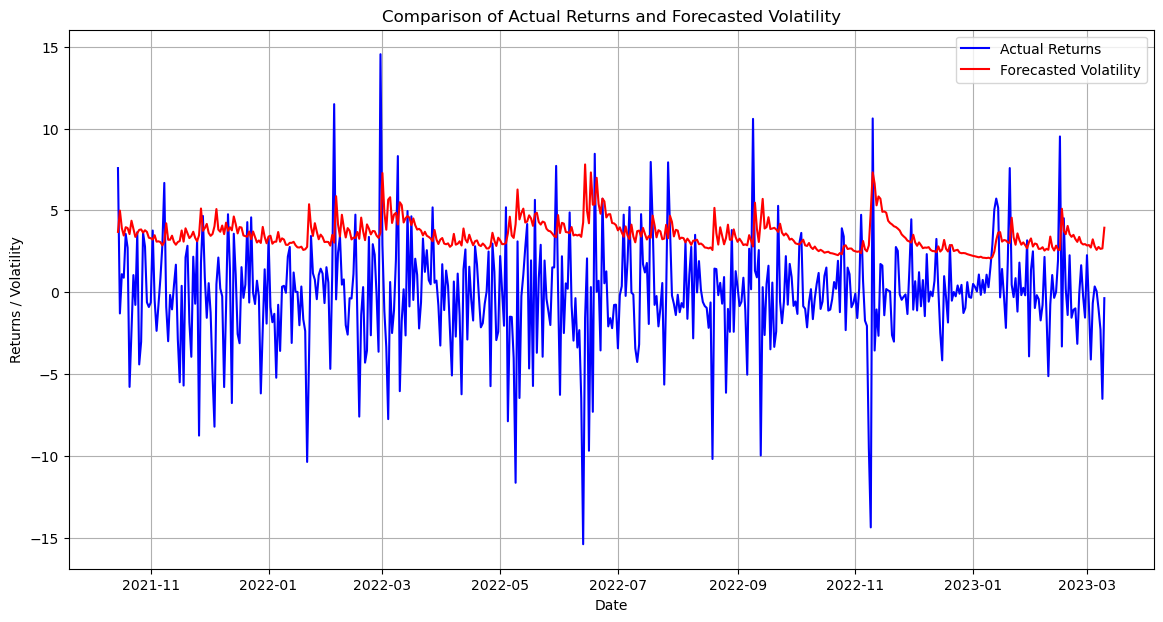

Root Mean Squared Error (RMSE): 4.957133538907196
Mean Absolute Error (MAE): 4.058645571211701
Theil's U Statistic: 0.7246837626764162
Hit Rate: 0.47265625


In [43]:
predicted_variance = []
for i in range(len(test)):
    # Update the model with one more step
    temp_data = pd.concat([train, test.iloc[:i]])
    model = arch_model(temp_data['return'], mean='Zero', vol='Garch', p=1, q=3)
    res = model.fit(disp='off', last_obs=len(train) + i)

    # Forecast the next day variance
    temp_forecast = res.forecast(horizon=1)
    predicted_variance.append(temp_forecast.variance.values[-1, -1])

predicted_volatility = np.sqrt(predicted_variance)  # Taking the square root to get the volatility


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assumed that predicted_volatility and test['return'] are already defined and available

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['return'], predicted_volatility))

# Calculate MAE
mae = mean_absolute_error(test['return'], predicted_volatility)

# Calculate Theil's U Statistic
numerator = np.sqrt(np.sum((test['return'] - predicted_volatility) ** 2))
denominator = (np.sqrt(np.sum(test['return'] ** 2)) + np.sqrt(np.sum(predicted_volatility ** 2)))
theils_u = numerator / denominator

# Calculate Hit Rate
# Assuming that a "hit" is defined as both the forecasted and actual values having the same sign
hits = np.sum(np.sign(test['return']) == np.sign(predicted_volatility))
hit_rate = hits / len(test['return'])

# Plotting the comparison
plt.figure(figsize=(14, 7))
plt.plot(test.index, test['return'], label='Actual Returns', color='blue')
plt.plot(test.index, predicted_volatility, label='Forecasted Volatility', color='red')
plt.title('Comparison of Actual Returns and Forecasted Volatility')
plt.xlabel('Date')
plt.ylabel('Returns / Volatility')
plt.legend()
plt.grid(True)
plt.show()

# Print evaluation metrics
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Theil's U Statistic:", theils_u)
print("Hit Rate:", hit_rate)
